# Testing Outsourced Code

In [1384]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [1385]:
from importlib import reload  

import topicflow.utils  as tp_utils
import topicflow.data   as tp_data
import topicflow.models as tp_models

tp_utils  = reload(tp_utils)
tp_data   = reload(tp_data)
tp_models = reload(tp_models)

## Settings

In [1386]:
N_docs = 1000
sqrt_N_vocab = 5
N_words = 100

N_vocab = int(sqrt_N_vocab**2)

## Generating Data

In [1387]:
data_fixed_N  = tp_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words_fixed=N_words)
data_random_N = tp_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words_rate=N_words)

## Modelling

### Fixed $I_d=N, \ \forall \ d\in \{1, \, \dots, D\}$:

In [1388]:
Theta, Pi, _, _, W_DId = data_fixed_N.extract_params()

Presenting documents [102 435 860 270 106  71 700  20 614 121]


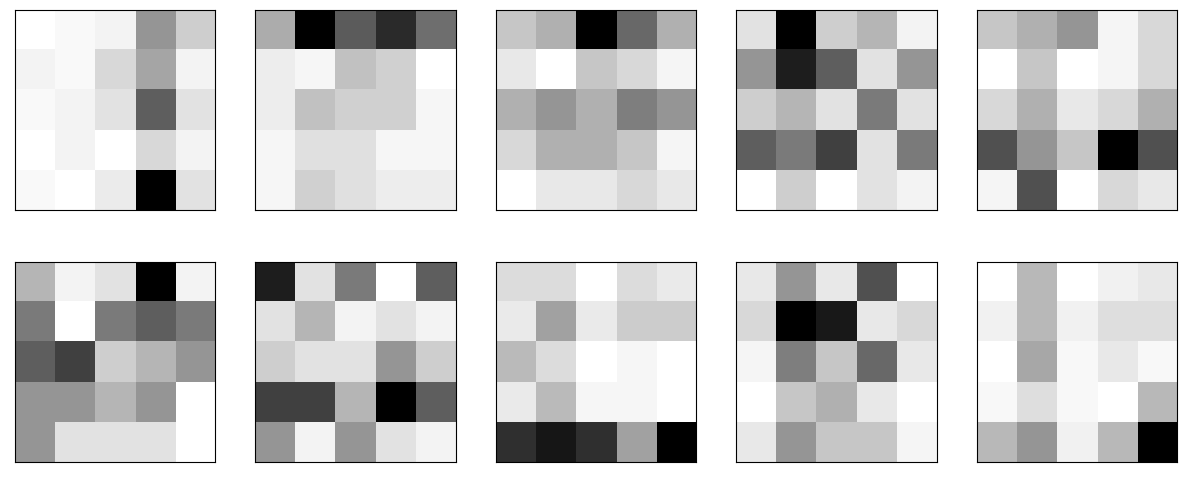

In [1389]:
fig = tp_utils.visualize_random_docs(W_DId, sqrt_N_vocab)

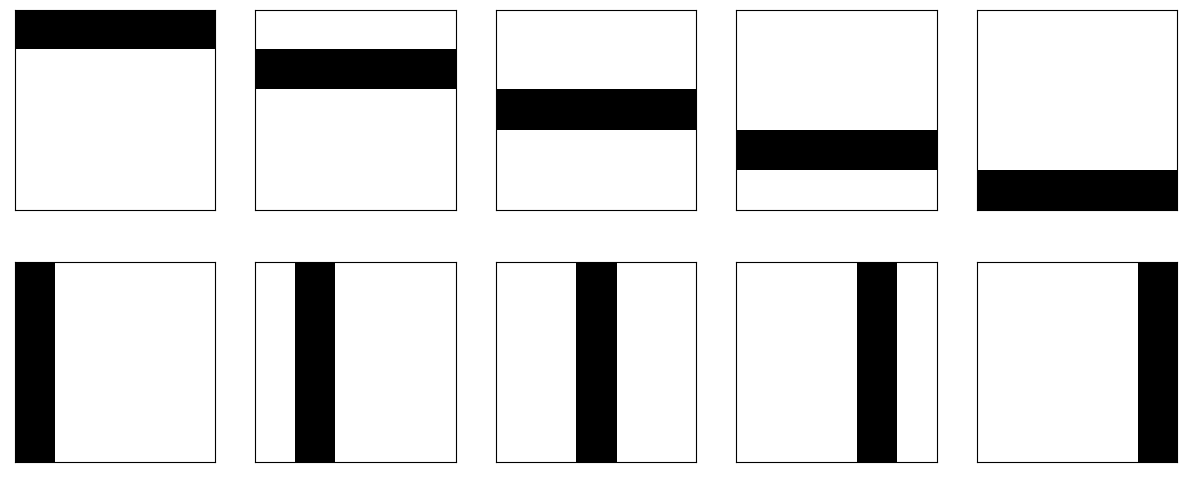

In [1390]:
fig = tp_utils.visualize_topics(Theta, 2, sqrt_N_vocab)

In [1391]:
model_fixedN = tp_models.LDA(N_topics=2*sqrt_N_vocab)
model_fixedN.fit(W_DId, n_batch=1000, n_epochs=30, verbose=1) 

100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


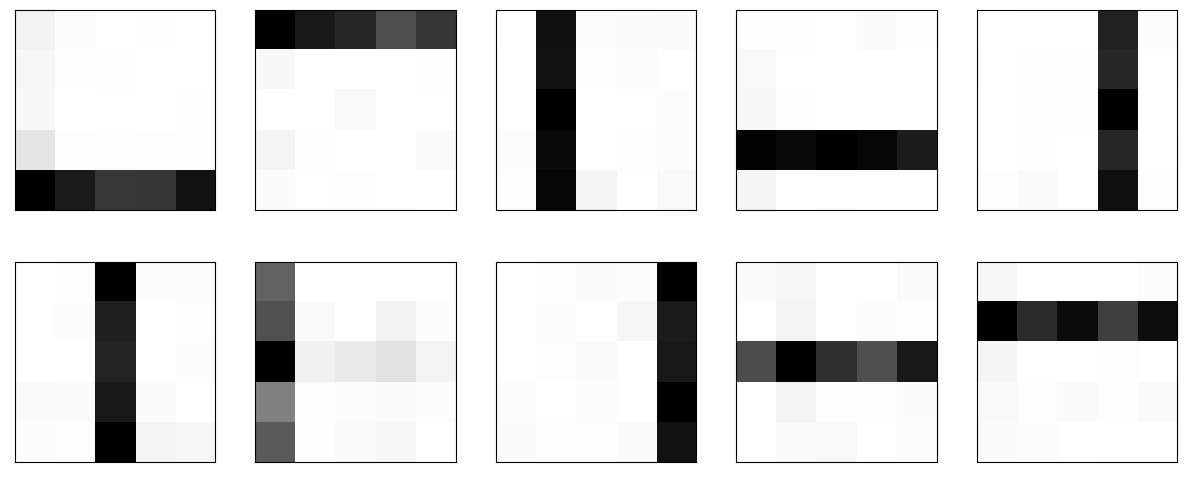

In [1392]:
fig = tp_utils.visualize_topics(model_fixedN.Theta, 2, sqrt_N_vocab)

### Testing `LDA.predict()`

In [1393]:
data_test  = tp_data.squareLDDocuments(
    N_docs=10, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words_rate=N_words,
    Theta_overwrite=model_fixedN.Theta,
    alpha=1.)

In [1394]:
Theta_test, Pi_test, _, _, W_DId_test = data_test.extract_params()

100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


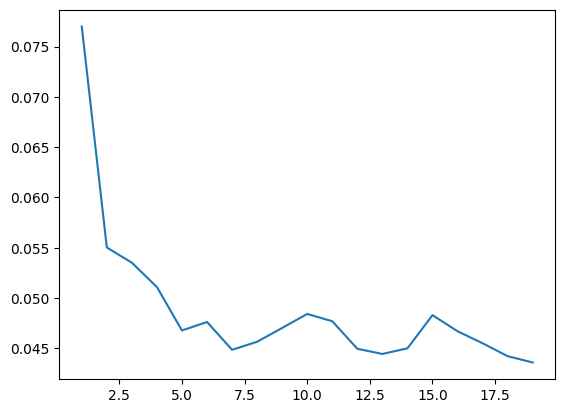

In [1395]:
errs    = []
N_iters = []

for N_iter in tqdm(range(1, 20)):
    Pi_pred = model_fixedN.predict(W_DId_test, N_iter=N_iter)
    errs.append(np.mean(np.abs(Pi_pred - Pi_test)))
    N_iters.append(N_iter)

plt.plot(N_iters, errs)

### Random $I_d$:

In [919]:
Theta, Pi, _, _, W_DId = data_random_N.extract_params()

Presenting documents [ 87 658 498 581 394  41   1 743 752 679]


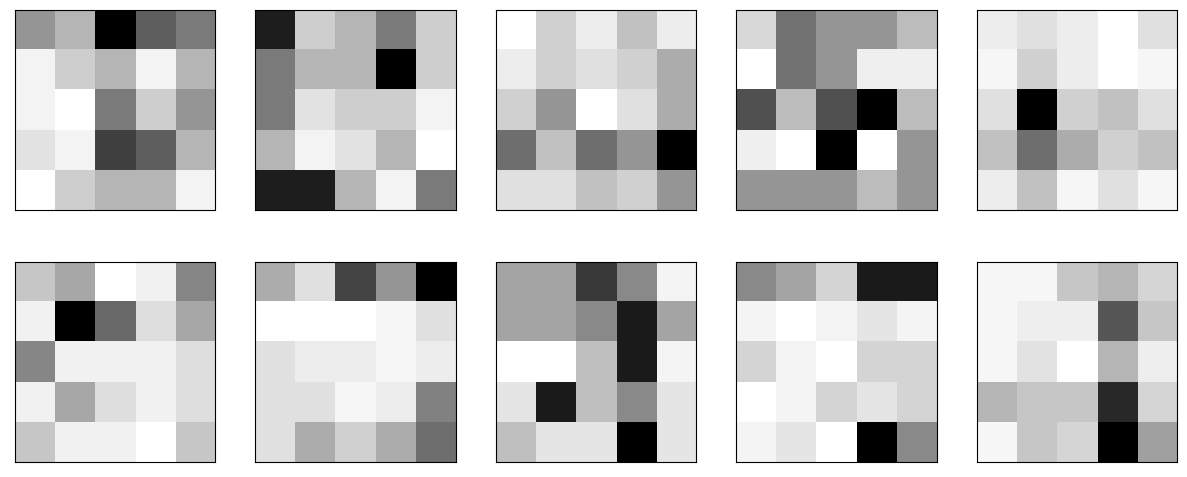

In [920]:
fig = tp_utils.visualize_random_docs(W_DId, sqrt_N_vocab)

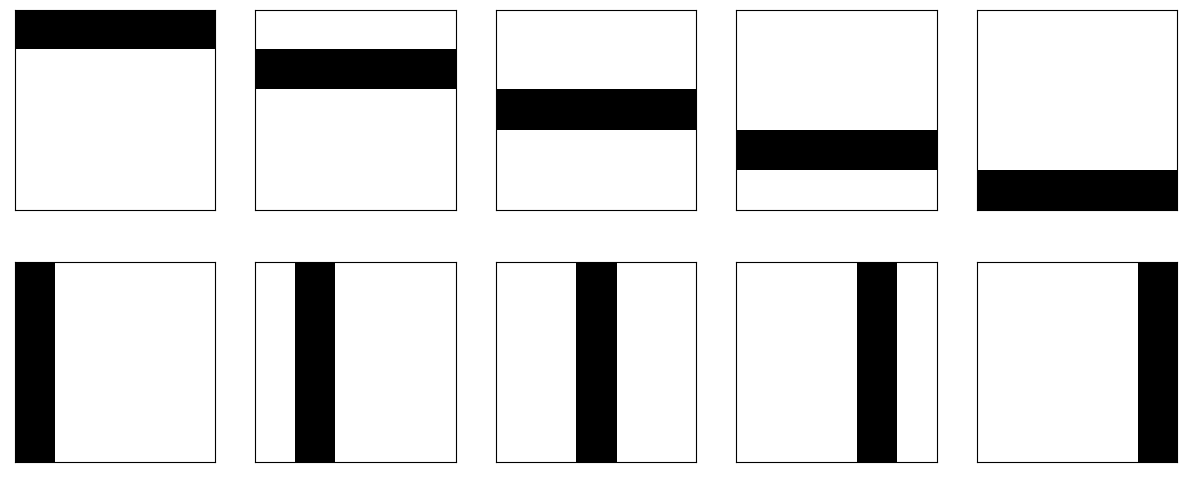

In [921]:
fig = tp_utils.visualize_topics(Theta, 2, sqrt_N_vocab)

In [926]:
model_randomN = tp_models.LDA(N_topics=2*sqrt_N_vocab)
model_randomN.fit(W_DId, n_batch=1000, n_epochs=30) # , n_batch=250, n_epochs=5

100%|██████████| 30/30 [00:08<00:00,  3.67it/s]


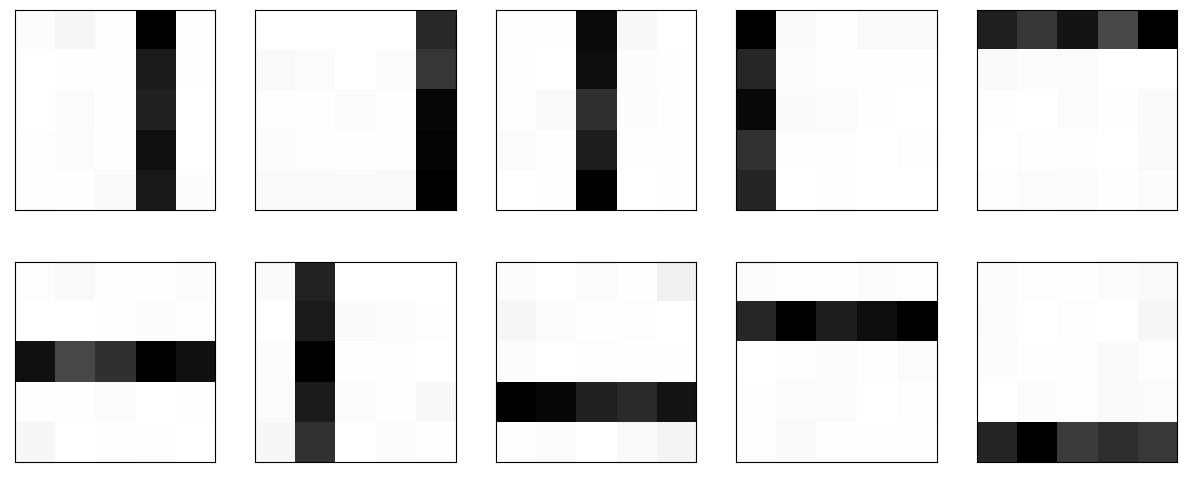

In [927]:
fig = tp_utils.visualize_topics(model_randomN.Theta, 2, sqrt_N_vocab)

## Further Tests

In [930]:
K = 10
data_larger = tp_data.squareLDDocuments(10000, K, N_words_rate=200)
Theta, Pi, _, _, W_DId = data_larger.extract_params()

In [931]:
model_larger = tp_models.LDA(N_topics=2*K)
model_larger.fit(W_DId, n_batch=2056, n_epochs=30, verbose=1)

100%|██████████| 30/30 [12:19<00:00, 24.65s/it]


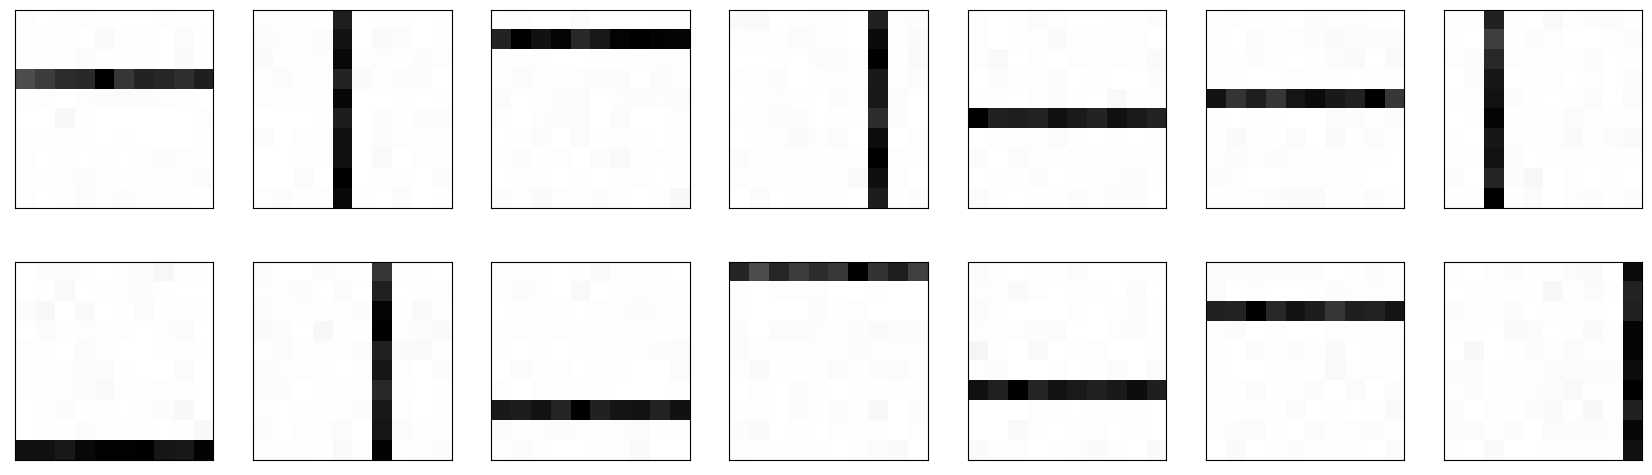

In [932]:
fig = tp_utils.visualize_topics(model_larger.Theta, 2, 7)